In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import multivariate_normal
import gpflow
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import pickle
import sys
sys.path.insert(1, "../ipsc_gp_clustering")
from splitgpm import SplitGPM
from utils import gen_gsea_df
import gpflow.training.monitor as mon
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(2021)

/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/work-zfs/abattle4/josh/ebpilot/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/work-zfs/abattle4/josh/ebpilot/myenv

In [2]:
hi_res=True

Functions for splitGPM

In [3]:
def normalize(X):
    return X / X.sum(1)[:, None]

In [4]:
def run_splitGPM(X, Y):
    gpflow.reset_default_graph_and_session()
    name = 'test'
    minibatch_size = 500
    W1_init = normalize(np.random.random(size=(C, K1)))
    W2_init = normalize(np.random.random(size=(G, K2)))
    with gpflow.defer_build():
        kernel = mk.SharedIndependentMok(gpflow.kernels.RBF(1, active_dims=[0]), K1 * K2)
        Z = np.linspace(0, 1, T)[:, None].astype(np.float64)
        feature = gpflow.features.InducingPoints(Z)
        feature = mf.SharedIndependentMof(feature)
        model = SplitGPM(X_ind, Y_ind, np.log(W1_init + 1e-5), np.log(W2_init + 1e-5), kernel, gpflow.likelihoods.Gaussian(), feat=feature, minibatch_size=minibatch_size, name=name)
    model.compile()
    model.W1.set_trainable(True)  # learn cell assignments
    model.W2.set_trainable(True)  # learn gene assignments
    model.feature.set_trainable(True)  # move inducing points
    model.kern.set_trainable(True)  # learn kernel parameters
    model.likelihood.set_trainable(True)  # learn likelihood parameters
    adam = gpflow.train.AdamOptimizer(0.005)
    adam.minimize(model, maxiter=10000)
    return(model)

In [5]:
def view_gsea(m, genedict):
    assignments = m.W2.value.argmax(1)
    gene_names = np.array(list(genedict.keys()))
    confidence = m.W2.value.max(1)
    assignments = pd.DataFrame({'gene': gene_names, 'clust_1cell_10gene': assignments, 'conf_1cell_10gene': confidence})
    clusters = assignments['clust_1cell_10gene']
    gene_names = assignments['gene']
    gsea_results = gen_gsea_df(clusters, gene_names, 'gsea_output', threshold=1e-2, rerun=True)
    idx = pd.IndexSlice
    active_clusters = np.where(np.any(gsea_results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
    active_results = pd.concat([gsea_results.T.iloc[:, gsea_results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
    active_gene_sets = np.where(np.any(active_results.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
    active_results = active_results.iloc[active_gene_sets]
    return(active_results)

## Endothelial lineage

### Stratified by individual

In [6]:
if not hi_res:
    X_ind = np.loadtxt("../data/endo.dpt.ind.X.txt")
    Y_ind = np.loadtxt("../data/endo.dpt.ind.Y.txt")
else:
    X_ind = np.loadtxt("../data/endo.dpt.hires.ind.X.txt")
    Y_ind = np.loadtxt("../data/endo.dpt.hires.ind.Y.txt") 

In [7]:
C=3
G=int(max(X_ind[:,2])+1)
T=5
K1=1
K2=5
N=C*T

In [8]:
m = run_splitGPM(X_ind, Y_ind)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Tensor("test/add_6:0", shape=(?, 5), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 5), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


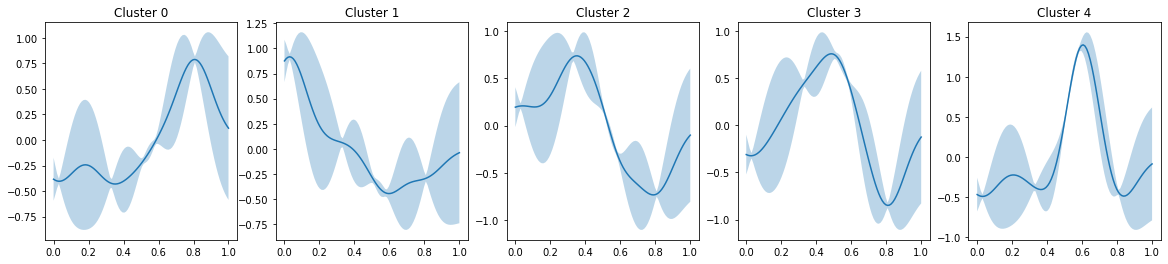

In [9]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)

In [10]:
if not hi_res:
    with open("../data/endo.dpt.ind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/endo.dpt.hires.ind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()

In [11]:
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,0,1,2,4
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_TNFA_SIGNALING_VIA_NFKB,1.06848e-05,1,1,1
HALLMARK_MITOTIC_SPINDLE,1,1,0.000749352,1
HALLMARK_G2M_CHECKPOINT,1,1,1.81446e-19,1
HALLMARK_MTORC1_SIGNALING,1,0.00243083,0.48994,1
HALLMARK_E2F_TARGETS,1,1,1.37115e-18,1
HALLMARK_MYC_TARGETS_V1,1,0.184287,9.66338e-06,1
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1,1,1,5.42229e-07
HALLMARK_COAGULATION,0.00420569,1,1,1
HALLMARK_KRAS_SIGNALING_UP,0.00213519,1,1,1


### Stratified by batch

In [12]:
if not hi_res:
    X_ind = np.loadtxt("../data/endo.dpt.batch.X.txt")
    Y_ind = np.loadtxt("../data/endo.dpt.batch.Y.txt")
else:
    X_ind = np.loadtxt("../data/endo.dpt.hires.batch.X.txt")
    Y_ind = np.loadtxt("../data/endo.dpt.hires.batch.Y.txt")

In [13]:
C=3
G=int(max(X_ind[:,2])+1)
T=5
K1=1
K2=5
N=C*T

In [14]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 5), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 5), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


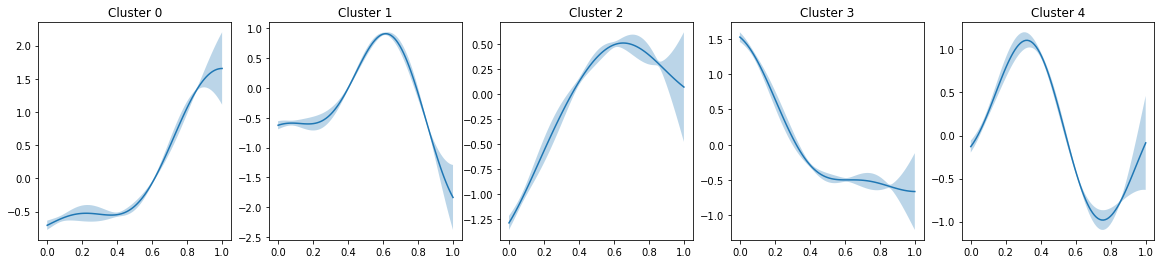

In [15]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)

In [16]:
if not hi_res:
    with open("../data/endo.dpt.batch.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/endo.dpt.hires.batch.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()

In [17]:
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,0,1,3,4
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000174237,1,1,1
HALLMARK_MITOTIC_SPINDLE,1,1,1,0.0092255
HALLMARK_G2M_CHECKPOINT,1,1,1,3.46442e-18
HALLMARK_APOPTOSIS,0.0012492,1,1,1
HALLMARK_INTERFERON_GAMMA_RESPONSE,0.00968748,1,1,1
HALLMARK_COMPLEMENT,0.000844793,1,1,1
HALLMARK_MTORC1_SIGNALING,1,1,0.000307116,1
HALLMARK_E2F_TARGETS,1,1,1,3.61959e-22
HALLMARK_MYC_TARGETS_V1,1,1,0.370398,4.97298e-06


### Stratified by batch and individual

In [18]:
if not hi_res:
    X_ind = np.loadtxt("../data/endo.dpt.batchind.X.txt")
    Y_ind = np.loadtxt("../data/endo.dpt.batchind.Y.txt")
else:
    X_ind = np.loadtxt("../data/endo.dpt.hires.batchind.X.txt")
    Y_ind = np.loadtxt("../data/endo.dpt.hires.batchind.Y.txt")

In [19]:
C=9
G=int(max(X_ind[:,2])+1)
T=5
K1=3
K2=5
N=C*T

In [20]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


How were (cell-line/ batch) pairs clustered?

In [21]:
if not hi_res:
    with open("../data/endo.dpt.batchind.linedict.pickle", 'rb') as f:
        linedict = pickle.load(f)
        f.close()
else:
    with open("../data/endo.dpt.hires.batchind.linedict.pickle", 'rb') as f:
        linedict = pickle.load(f)
        f.close()

In [22]:
cell_clusts = pd.DataFrame(data=linedict.values(), columns=["cell line/batch"])
cell_clusts['assignment'] = m.W1.value.argmax(1)
cell_clusts

,cell line/batch,assignment
0,SNG-NA18511--Batch1,2
1,SNG-NA18511--Batch2,2
2,SNG-NA18511--Batch3,2
3,SNG-NA18858--Batch1,1
4,SNG-NA18858--Batch2,1
5,SNG-NA18858--Batch3,1
6,SNG-NA19160--Batch1,2
7,SNG-NA19160--Batch2,2
8,SNG-NA19160--Batch3,2


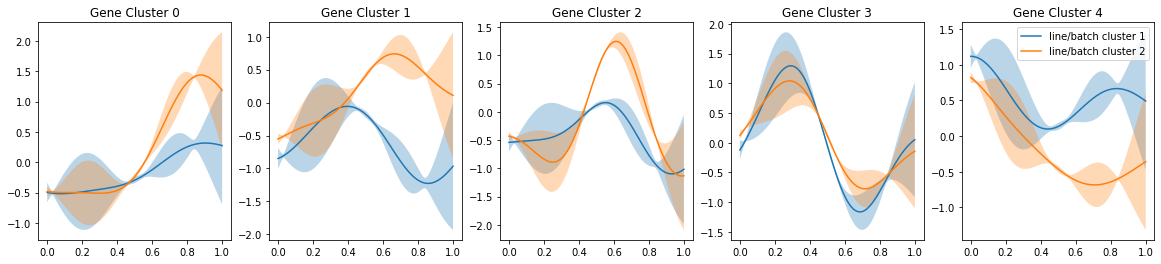

In [23]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
line_leg = []
for k in range(K1):
    if sum(a1 == k) == 0:
        continue  # no need to plot empty modules
    else:
        line_leg.append("line/batch cluster " + str(k))
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Gene Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
ax[l%5].legend(line_leg)

In [24]:
if not hi_res:
    with open("../data/endo.dpt.batchind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/endo.dpt.hires.batchind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()

In [25]:
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,0,1,2,3,4
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_TNFA_SIGNALING_VIA_NFKB,1.00714e-07,1,1,1,1
HALLMARK_G2M_CHECKPOINT,1,1,1,7.51983e-07,1
HALLMARK_APOPTOSIS,7.84836e-05,1,1,1,1
HALLMARK_ANDROGEN_RESPONSE,1,0.00706542,1,1,1
HALLMARK_APICAL_JUNCTION,0.000470291,1,1,1,1
HALLMARK_COMPLEMENT,1.37884e-05,1,1,1,1
HALLMARK_MTORC1_SIGNALING,1,1,1,1,6.57856e-06
HALLMARK_E2F_TARGETS,1,1,1,2.29089e-11,0.782356
HALLMARK_MYC_TARGETS_V2,1,1,1,1,0.00101437


How consistent is this cell line/batch clustering?

In [26]:
n_runs = 10
similarity = np.zeros([C,C], dtype=int)
for i in range(n_runs):
    m = run_splitGPM(X_ind, Y_ind)
    for j in range(C):
        for k in range(j):
            if m.W1.value.argmax(1)[j] == m.W1.value.argmax(1)[k]:
                similarity[j,k] += 1
                similarity[k,j] += 1
for j in range(C):
    similarity[j,j] = n_runs

Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", sh

[Text(0.5, 0, 'SNG-NA18511--Batch1'),
 Text(1.5, 0, 'SNG-NA18511--Batch2'),
 Text(2.5, 0, 'SNG-NA18511--Batch3'),
 Text(3.5, 0, 'SNG-NA18858--Batch1'),
 Text(4.5, 0, 'SNG-NA18858--Batch2'),
 Text(5.5, 0, 'SNG-NA18858--Batch3'),
 Text(6.5, 0, 'SNG-NA19160--Batch1'),
 Text(7.5, 0, 'SNG-NA19160--Batch2'),
 Text(8.5, 0, 'SNG-NA19160--Batch3')]

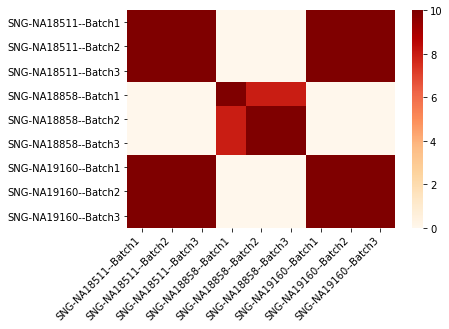

In [27]:
hm = sns.heatmap(similarity, cmap="OrRd",
           xticklabels=linedict.values(),
           yticklabels=linedict.values())
hm.set_xticklabels(hm.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')

## Hepatocyte lineage

### Stratified by individual

Note that one sample was removed - the second individual at the last timepoint

In [28]:
if not hi_res:
    X_ind = np.loadtxt("../data/hep.dpt.ind.X.txt")
    Y_ind = np.loadtxt("../data/hep.dpt.ind.Y.txt")
else:
    X_ind = np.loadtxt("../data/hep.dpt.hires.ind.X.txt")
    Y_ind = np.loadtxt("../data/hep.dpt.hires.ind.Y.txt")

In [29]:
C=3
G=int(max(X_ind[:,2])+1)
T=5
K1=1
K2=5
N=C*T

In [30]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 5), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 5), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


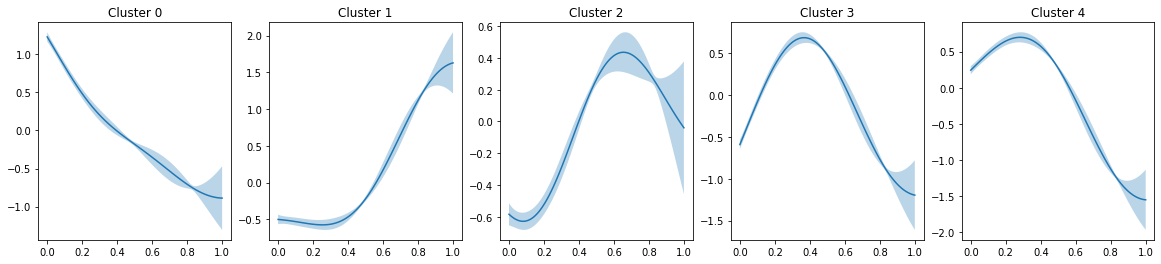

In [31]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)

In [32]:
if not hi_res:
    with open("../data/hep.dpt.ind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/hep.dpt.hires.ind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()

In [33]:
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,1,2,4
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_TNFA_SIGNALING_VIA_NFKB,1,0.00493268,1
HALLMARK_CHOLESTEROL_HOMEOSTASIS,1.66124e-06,1,1
HALLMARK_MITOTIC_SPINDLE,1,1,4.08719e-10
HALLMARK_G2M_CHECKPOINT,1,1,2.56011e-28
HALLMARK_ADIPOGENESIS,4.71161e-05,1,1
HALLMARK_COMPLEMENT,2.61338e-05,1,1
HALLMARK_E2F_TARGETS,1,1,1.63956e-36
HALLMARK_MYC_TARGETS_V1,1,1,2.55813e-09
HALLMARK_XENOBIOTIC_METABOLISM,2.42258e-09,1,1


### Stratified by batch

In [34]:
if not hi_res:
    X_ind = np.loadtxt("../data/hep.dpt.batch.X.txt")
    Y_ind = np.loadtxt("../data/hep.dpt.batch.Y.txt")
else:
    X_ind = np.loadtxt("../data/hep.dpt.hires.batch.X.txt")
    Y_ind = np.loadtxt("../data/hep.dpt.hires.batch.Y.txt")

In [35]:
C=3
G=int(max(X_ind[:,2])+1)
T=5
K1=1
K2=5
N=C*T

In [36]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 5), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 5), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


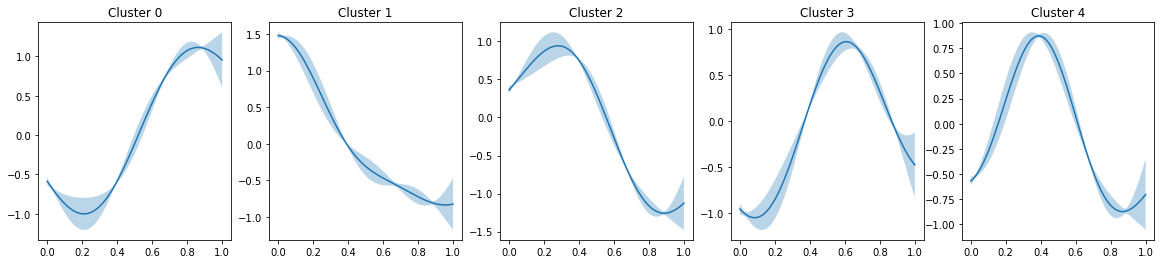

In [37]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)

In [38]:
if not hi_res:
    with open("../data/hep.dpt.batch.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/hep.dpt.hires.batch.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()

In [39]:
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,0,1,2
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_CHOLESTEROL_HOMEOSTASIS,4.92928e-05,1,1
HALLMARK_MITOTIC_SPINDLE,1,1,1.39438e-11
HALLMARK_G2M_CHECKPOINT,1,1,1.63421e-27
HALLMARK_ADIPOGENESIS,4.38593e-06,1,1
HALLMARK_ANDROGEN_RESPONSE,0.00111495,1,1
HALLMARK_COMPLEMENT,3.40796e-05,1,1
HALLMARK_E2F_TARGETS,1,1,9.07518e-30
HALLMARK_MYC_TARGETS_V1,1,1,3.36638e-08
HALLMARK_MYC_TARGETS_V2,1,0.00442956,1


### Stratified by both batch and individual

In [40]:
if not hi_res:
    X_ind = np.loadtxt("../data/hep.dpt.batchind.X.txt")
    Y_ind = np.loadtxt("../data/hep.dpt.batchind.Y.txt")
else:
    X_ind = np.loadtxt("../data/hep.dpt.hires.batchind.X.txt")
    Y_ind = np.loadtxt("../data/hep.dpt.hires.batchind.Y.txt")

In [41]:
C=9
G=int(max(X_ind[:,2])+1)
T=5
K1=3
K2=5
N=C*T

In [42]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


In [43]:
if not hi_res:
    with open("../data/hep.dpt.batchind.linedict.pickle", 'rb') as f:
        linedict = pickle.load(f)
        f.close()
else:
    with open("../data/hep.dpt.hires.batchind.linedict.pickle", 'rb') as f:
        linedict = pickle.load(f)
        f.close()
cell_clusts = pd.DataFrame(data=linedict.values(), columns=["cell line/batch"])
cell_clusts['assignment'] = m.W1.value.argmax(1)
cell_clusts

,cell line/batch,assignment
0,SNG-NA18511--Batch1,0
1,SNG-NA18511--Batch2,0
2,SNG-NA18511--Batch3,2
3,SNG-NA18858--Batch1,2
4,SNG-NA18858--Batch2,2
5,SNG-NA18858--Batch3,2
6,SNG-NA19160--Batch1,0
7,SNG-NA19160--Batch2,0
8,SNG-NA19160--Batch3,2


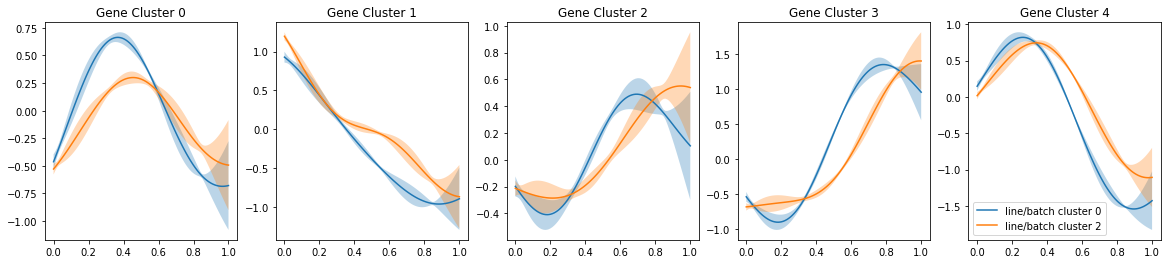

In [44]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
line_leg = []
for k in range(K1):
    if sum(a1 == k) == 0:
        continue  # no need to plot empty modules
    else:
        line_leg.append("line/batch cluster " + str(k))
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Gene Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
ax[l%5].legend(line_leg)

In [45]:
if not hi_res:
    with open("../data/hep.dpt.batchind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/hep.dpt.hires.batchind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()    
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,1,3,4
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_CHOLESTEROL_HOMEOSTASIS,1,2.11447e-06,1
HALLMARK_MITOTIC_SPINDLE,1,1,1.10513e-09
HALLMARK_G2M_CHECKPOINT,1,1,1.33349e-20
HALLMARK_ADIPOGENESIS,1,2.20281e-05,1
HALLMARK_ANDROGEN_RESPONSE,1,0.00384152,1
HALLMARK_COMPLEMENT,1,0.000290349,1
HALLMARK_MTORC1_SIGNALING,0.00367589,1,1
HALLMARK_E2F_TARGETS,1,1,5.70599e-20
HALLMARK_MYC_TARGETS_V1,1,1,7.52984e-08


In [46]:
n_runs = 10
similarity = np.zeros([C,C], dtype=int)
for i in range(n_runs):
    m = run_splitGPM(X_ind, Y_ind)
    for j in range(C):
        for k in range(j):
            if m.W1.value.argmax(1)[j] == m.W1.value.argmax(1)[k]:
                similarity[j,k] += 1
                similarity[k,j] += 1
for j in range(C):
    similarity[j,j] = n_runs

Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", sh

[Text(0.5, 0, 'SNG-NA18511--Batch1'),
 Text(1.5, 0, 'SNG-NA18511--Batch2'),
 Text(2.5, 0, 'SNG-NA18511--Batch3'),
 Text(3.5, 0, 'SNG-NA18858--Batch1'),
 Text(4.5, 0, 'SNG-NA18858--Batch2'),
 Text(5.5, 0, 'SNG-NA18858--Batch3'),
 Text(6.5, 0, 'SNG-NA19160--Batch1'),
 Text(7.5, 0, 'SNG-NA19160--Batch2'),
 Text(8.5, 0, 'SNG-NA19160--Batch3')]

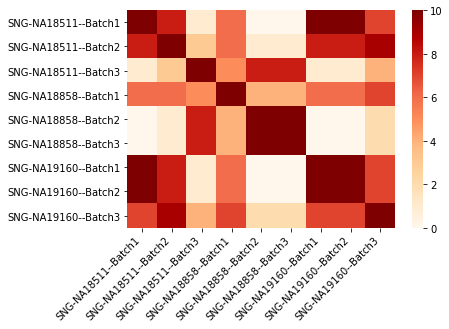

In [47]:
hm = sns.heatmap(similarity, cmap="OrRd",
           xticklabels=linedict.values(),
           yticklabels=linedict.values())
hm.set_xticklabels(hm.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')

## Neuronal lineage

### Stratified by individual

In [48]:
if not hi_res:
    X_ind = np.loadtxt("../data/neur.dpt.ind.X.txt")
    Y_ind = np.loadtxt("../data/neur.dpt.ind.Y.txt")
else:
    X_ind = np.loadtxt("../data/neur.dpt.hires.ind.X.txt")
    Y_ind = np.loadtxt("../data/neur.dpt.hires.ind.Y.txt")    

In [49]:
C=3
G=int(max(X_ind[:,2])+1)
T=5
K1=1
K2=5
N=C*T

In [50]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 5), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 5), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


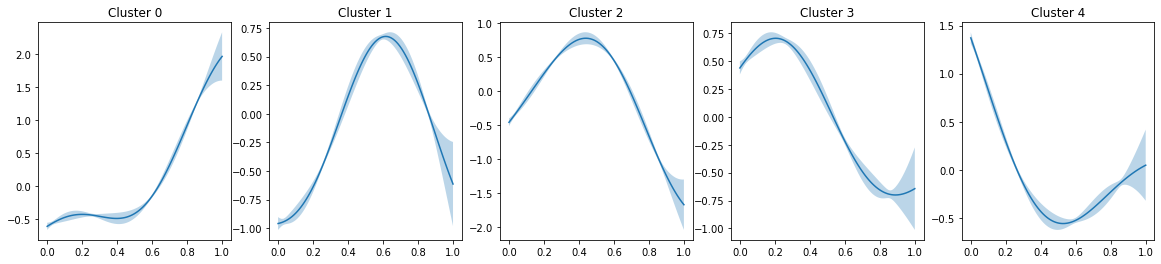

In [51]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)

In [52]:
if not hi_res:
    with open("../data/neur.dpt.ind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/neur.dpt.hires.ind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()    

In [53]:
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,2,3,4
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_G2M_CHECKPOINT,2.46875e-11,3.66335e-05,1
HALLMARK_ESTROGEN_RESPONSE_EARLY,1,1,0.00131406
HALLMARK_INTERFERON_GAMMA_RESPONSE,1,1,0.0085254
HALLMARK_MTORC1_SIGNALING,1,0.000503455,0.402503
HALLMARK_E2F_TARGETS,2.18594e-11,3.69245e-06,1
HALLMARK_MYC_TARGETS_V1,8.22298e-05,0.0628844,1
HALLMARK_MYC_TARGETS_V2,1,0.000256203,1


### Stratified by batch

In [54]:
if not hi_res:
    X_ind = np.loadtxt("../data/neur.dpt.batch.X.txt")
    Y_ind = np.loadtxt("../data/neur.dpt.batch.Y.txt")
else:
    X_ind = np.loadtxt("../data/neur.dpt.hires.batch.X.txt")
    Y_ind = np.loadtxt("../data/neur.dpt.hires.batch.Y.txt")    

In [55]:
C=3
G=int(max(X_ind[:,2])+1)
T=5
K1=1
K2=5
N=C*T

In [56]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 5), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 5), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


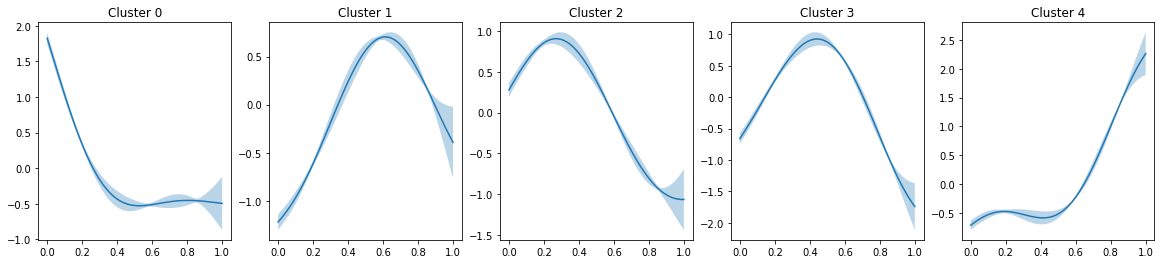

In [57]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)

In [58]:
if not hi_res:
    with open("../data/neur.dpt.batch.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/neur.dpt.hires.batch.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()

In [59]:
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,0,2,3
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_MITOTIC_SPINDLE,1,0.00042146,1
HALLMARK_G2M_CHECKPOINT,1,5.19507e-14,0.0112541
HALLMARK_ESTROGEN_RESPONSE_EARLY,0.0004536,1,1
HALLMARK_INTERFERON_GAMMA_RESPONSE,0.00321537,1,1
HALLMARK_MTORC1_SIGNALING,0.186078,9.515e-05,1
HALLMARK_E2F_TARGETS,1,2.53371e-14,0.00499829
HALLMARK_MYC_TARGETS_V1,1,0.00375471,0.0791595
HALLMARK_MYC_TARGETS_V2,1,0.000502374,1
HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.00107669,1,1


### Stratified by batch and individual

In [60]:
if not hi_res:
    X_ind = np.loadtxt("../data/neur.dpt.batchind.X.txt")
    Y_ind = np.loadtxt("../data/neur.dpt.batchind.Y.txt")
else:
    X_ind = np.loadtxt("../data/neur.dpt.hires.batchind.X.txt")
    Y_ind = np.loadtxt("../data/neur.dpt.hires.batchind.Y.txt")    

In [61]:
C=9
G=int(max(X_ind[:,2])+1)
T=5
K1=3
K2=5
N=C*T

In [62]:
m = run_splitGPM(X_ind, Y_ind)

Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)


In [63]:
if not hi_res:
    with open("../data/neur.dpt.batchind.linedict.pickle", 'rb') as f:
        linedict = pickle.load(f)
        f.close()
else:
    with open("../data/neur.dpt.hires.batchind.linedict.pickle", 'rb') as f:
        linedict = pickle.load(f)
        f.close()
cell_clusts = pd.DataFrame(data=linedict.values(), columns=["cell line/batch"])
cell_clusts['assignment'] = m.W1.value.argmax(1)
cell_clusts

,cell line/batch,assignment
0,SNG-NA18511--Batch1,2
1,SNG-NA18511--Batch2,0
2,SNG-NA18511--Batch3,0
3,SNG-NA18858--Batch1,0
4,SNG-NA18858--Batch2,0
5,SNG-NA18858--Batch3,0
6,SNG-NA19160--Batch1,2
7,SNG-NA19160--Batch2,2
8,SNG-NA19160--Batch3,0


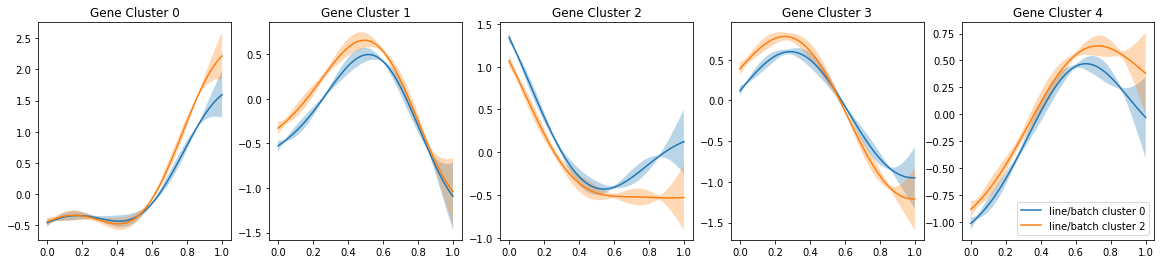

In [65]:
Xnew_ind = np.linspace(0, 1, 100)[:, None]
mu, var = m.predict_f(Xnew_ind)
fig, ax = plt.subplots(1,5, figsize=(20,4))
mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T
a1 = m.W1.value.argmax(1)[X_ind[:, 1].astype(int)]
a2 = m.W2.value.argmax(1)[X_ind[:, 2].astype(int)]
line_leg = []
for k in range(K1):
    if sum(a1 == k) == 0:
        continue  # no need to plot empty modules
    else:
        line_leg.append("line/batch cluster " + str(k))
    for l in range(K2):
        ax[l%5].plot(Xnew_ind, mu[:, l, k])
        ax[l%5].set_title("Gene Cluster %d" % l)
        ax[l%5].fill_between(
            Xnew_ind.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
ax[l%5].legend(line_leg)

In [66]:
if not hi_res:
    with open("../data/neur.dpt.batchind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
else:
    with open("../data/neur.dpt.hires.batchind.genedict.pickle", 'rb') as f:
        genedict = pickle.load(f)
        f.close()
active_results = view_gsea(m, genedict)
active_results.loc[:, pd.IndexSlice[:, 'bonferonni-adjusted']]

,0,2,3
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_MITOTIC_SPINDLE,1,1,1.93314e-07
HALLMARK_G2M_CHECKPOINT,1,1,4.43539e-21
HALLMARK_ESTROGEN_RESPONSE_EARLY,1,0.000399656,1
HALLMARK_MTORC1_SIGNALING,1,0.00736101,4.21017e-05
HALLMARK_E2F_TARGETS,1,1,1.99314e-28
HALLMARK_MYC_TARGETS_V1,1,1,3.37513e-09
HALLMARK_MYC_TARGETS_V2,1,1,0.000866363
HALLMARK_OXIDATIVE_PHOSPHORYLATION,1,0.00171769,1
HALLMARK_GLYCOLYSIS,1,0.887663,0.00515952


In [67]:
n_runs = 10
similarity = np.zeros([C,C], dtype=int)
for i in range(n_runs):
    m = run_splitGPM(X_ind, Y_ind)
    for j in range(C):
        for k in range(j):
            if m.W1.value.argmax(1)[j] == m.W1.value.argmax(1)[k]:
                similarity[j,k] += 1
                similarity[k,j] += 1
for j in range(C):
    similarity[j,j] = n_runs

Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", shape=(?, 15), dtype=float64)
Tensor("test/conditional/base_conditional/transpose:0", shape=(?, 15), dtype=float64)
Tensor("test/Reshape_2:0", shape=(?, 1), dtype=float64)
Tensor("test/add_6:0", sh

[Text(0.5, 0, 'SNG-NA18511--Batch1'),
 Text(1.5, 0, 'SNG-NA18511--Batch2'),
 Text(2.5, 0, 'SNG-NA18511--Batch3'),
 Text(3.5, 0, 'SNG-NA18858--Batch1'),
 Text(4.5, 0, 'SNG-NA18858--Batch2'),
 Text(5.5, 0, 'SNG-NA18858--Batch3'),
 Text(6.5, 0, 'SNG-NA19160--Batch1'),
 Text(7.5, 0, 'SNG-NA19160--Batch2'),
 Text(8.5, 0, 'SNG-NA19160--Batch3')]

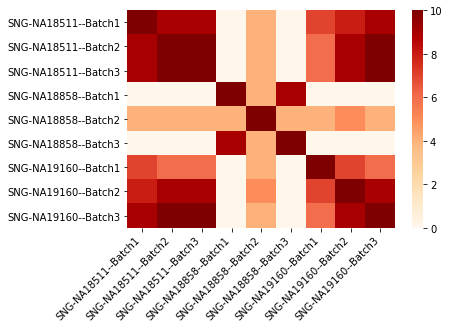

In [68]:
hm = sns.heatmap(similarity, cmap="OrRd",
           xticklabels=linedict.values(),
           yticklabels=linedict.values())
hm.set_xticklabels(hm.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')